# Simple Reinforcement Learning with Tensorflow Part 0: Q-Learning with Tables and Neural Networks

https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

## Notes

### Q-Learning algorithms

Q-Learning attempts to learn the value of being in a given state, and taking a specific action there - unlike policy gradient methods, which attempt to learn functions which directly map an observation to an action.

While both approaches ultimately allow us to take intelligent actions given a situation, the means of getting to that action differ significantly.

Instead of starting with a complex and unwieldy deep neural network, we will begin by implementing a simple lookup-table version of the algorithm, and then show how to implement a neural-network equivalent using Tensorflow. 

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state.

### Belman's Equation for Q-Learning

We make updates to our Q-table using something called the Bellman equation, which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! 

In equation form, the rule looks like this:

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0fe1ed37fa6eb19e26b55529c42f9d65b8f14a35)

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. 

If you think of the Q algorithm in the context of gradient descent, then `r + γ(max(Q(s’,a’))` is what we would like to approach, but we know that it is a noisy estimate of the true Q value for that given region. So instead of directly updating toward it, we take a small step in the direction that will make the Q value closer to the desired one.

By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state.

### The FrozenLake Environment

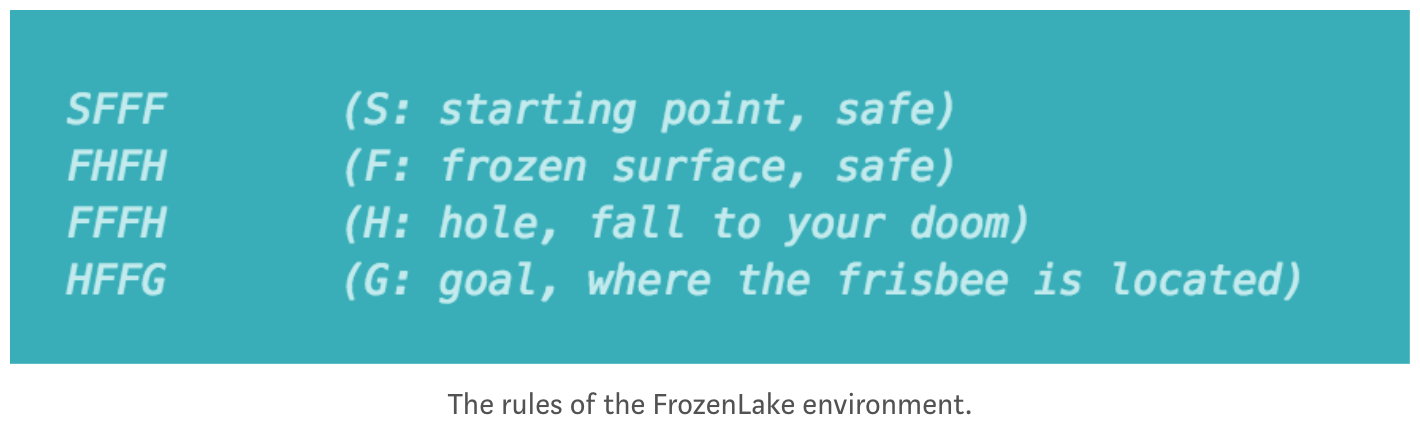

https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction (i.e. due to wind). The agent is rewarded for finding a walkable path to a goal tile.

Perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.



#### Matrix Implementation

In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. 

We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

#### Neural Network Implementation

Tables are great, but they don’t really scale. While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work.

We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action.

Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table.

The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in Bellman's equation above.

Eq2. Loss = ∑(Q-target - Q)²

While the network learns to solve the FrozenLake problem, it turns out it doesn’t do so quite as efficiently as the Q-Table. While neural networks allow for greater flexibility, they do so at the cost of stability when it comes to Q-Learning.

There are a number of possible extensions to our simple Q-Network which allow for greater performance and more robust learning. Two tricks in particular are referred to as Experience Replay and Freezing Target Networks. Those improvements and other tweaks were the key to getting Atari-playing Deep Q-Networks.

For more info on the theory behind Q-Learning, see this great post by Tambet Matiisen: http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/.

## Coding

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
tf.reset_default_graph()

env = gym.make('FrozenLake-v0')
print(env.action_space)
print(env.observation_space)
print(env.reward_range)
print(env.reset())
print(env.action_space.sample())

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Discrete(4)
Discrete(16)
(-inf, inf)
0
0


### Implement Q-Table learning algorithm¶

#### Implement Training

In [2]:
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n, env.action_space.n])

# Set learning parameters
lr = 0.8
y = .99

max_time_to_goal = 99
num_episodes = 4000

# create lists to contain total rewards
table_rList = []
table_jList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0

    # The Q-Table learning algorithm
    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily (with noise) picking from Q table
        # Adding noise as a means of encouraging exploration
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        # Update Q-Table with new knowledge
        Q[s,a] += lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break

    table_jList.append(j)
    table_rList.append(rAll)


Score over time: 0.5335


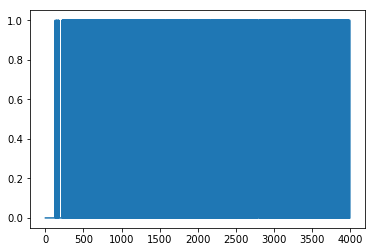

First 20 attempts


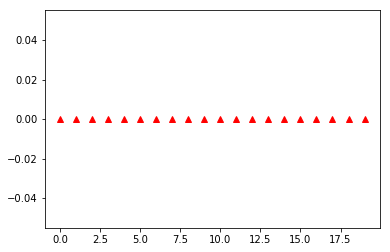

Last 20 attempts


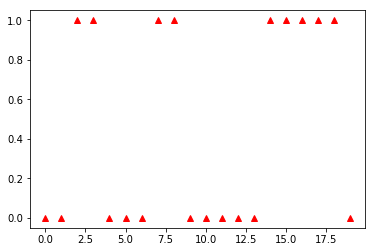

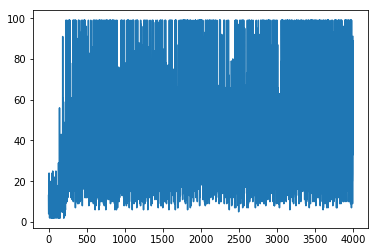

[[  4.19698215e-01   1.35427188e-02   9.69439235e-03   1.36874337e-02]
 [  1.17991865e-04   9.48930902e-03   1.28856154e-03   2.91712577e-01]
 [  3.66661508e-01   8.95708304e-03   1.39719161e-03   1.21861008e-02]
 [  2.70234010e-06   2.65928236e-06   3.24496101e-04   4.09717299e-04]
 [  4.85831710e-01   1.45107911e-03   3.03361425e-03   2.25384472e-03]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.56709109e-02   9.61049666e-09   7.59713015e-05   3.81132035e-08]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.27838303e-03   0.00000000e+00   7.45717588e-01]
 [  1.15524467e-03   3.93790572e-01   3.00094627e-03   3.22035450e-03]
 [  3.76496404e-01   5.45463428e-04   2.69558742e-04   6.44327155e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.84176182e-03   0.00000000e+00   7.85912396e-01   8.56170650e-03]
 [  0.

In [3]:
print("Score over time: " +  str(sum(table_rList)/num_episodes))

plt.plot(table_rList)
plt.show()
plt.close()

print("First 20 attempts")
plt.plot(range(20), table_rList[:20], 'r^')
plt.show()
plt.close()

print("Last 20 attempts")
plt.plot(range(20), table_rList[-20:], 'r^')
plt.show()
plt.close()


plt.plot(table_jList)
plt.show()
plt.close()


# print("Final Q-Table Values")
print(Q)

#### Test the training results

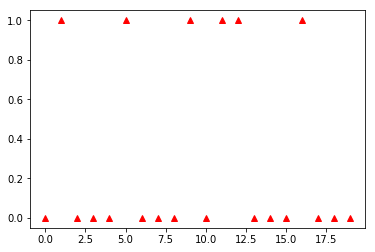

In [4]:
# Testing the results
test_res = []
max_time_to_goal = 500

for i in range(20):
    s = env.reset()

    rAll = 0
    d = False
    j = 0

    while j < max_time_to_goal:
        j+=1
        # Choose an action by greedily picking from Q table for the current state
        a = np.argmax(Q[s,:])

        # Get new state and reward from environment
        s1, r, d, info = env.step(a)

        rAll += r
        s = s1
        if d == True:
            break

    test_res.append(rAll)

    
plt.plot(range(len(test_res)), test_res, 'r^')
plt.show()
plt.close()


### Implementing Neural network

In [5]:
# Tensorflow "Hello world"
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

sess.close()

b'Hello, TensorFlow!'


In [6]:
# https://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# https://blog.jakuba.net/2017/05/30/tensorflow-visualization.html
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

#### Implementing the Network

In [10]:
try:
    test_sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    test_sess  = tf.Session()
testW = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01))

test_sess.run(tf.global_variables_initializer())
print(test_sess.run(testW))
print(test_sess.run(testW) == test_sess.run(testW))

test_sess.close()

[[  6.47846435e-04   1.63823960e-03   3.34444270e-03   6.22821786e-03]
 [  3.86174559e-03   9.48454626e-03   3.93516151e-03   1.45028951e-03]
 [  1.88342691e-03   6.59997575e-03   8.40660185e-03   4.93807998e-03]
 [  9.39835981e-03   9.50471498e-03   2.66857981e-03   4.68610879e-03]
 [  9.63958446e-03   8.91356438e-04   2.92547699e-03   1.01819518e-03]
 [  4.08067694e-03   8.96513648e-03   9.39111132e-03   8.97393189e-03]
 [  6.58343406e-03   5.43866260e-03   7.03262445e-03   5.92003576e-03]
 [  8.90135780e-05   7.46712182e-03   4.88882884e-03   9.54706874e-03]
 [  5.20864222e-03   3.55066522e-03   2.83608795e-03   9.66914836e-03]
 [  2.31714011e-03   1.37639756e-03   7.80900707e-04   1.18606561e-03]
 [  6.28517149e-03   4.06802632e-03   8.68672319e-03   4.81111649e-03]
 [  2.91117770e-03   7.95915909e-03   7.96247460e-03   6.26429403e-03]
 [  1.93532940e-03   9.12429672e-03   7.39508122e-03   1.76173565e-03]
 [  4.01774654e-03   5.68116037e-03   8.14254116e-03   1.23696798e-03]
 [  7.

In [14]:
try:
    sess.close()
    tf.reset_default_graph()
except:
    pass
finally:
    sess = tf.Session()

# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, env.observation_space.n], dtype=tf.float32, name="Current-State-Input")
# Initialize the weights of the neural links between the input nodes and each action node
W = tf.Variable(tf.random_uniform([env.observation_space.n, env.action_space.n], 0, 0.01), name="Input-to-Action-Weights")
# Caliculating the output nodes for a given input
Qout = tf.matmul(inputs1, W, name="Predicted-Actions-Quality")
# Each predicted action is the maximum output node for the given input
predict = tf.argmax(Qout, 1, name="Predicted-Best-Action")

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1, env.action_space.n], dtype=tf.float32, name="Actual-Action-Quality")
# Get the square difference for each cell and sum over all cells
loss = tf.reduce_sum(tf.square(nextQ - Qout), name="Current-Loss")
# Initialize a gradient descent trainer which will change the weights to reach a stable point
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1, name="Optimize-Weights-Gradient-Descent")
# Define the calculation goal - find a minimum loss
updateModel = trainer.minimize(loss)

print("Variables that will be trained:", tf.trainable_variables()[0])
show_graph(tf.get_default_graph())


Variables that will be trained: <tf.Variable 'Input-to-Action-Weights:0' shape=(16, 4) dtype=float32_ref>


In [15]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000

# create lists to contain total rewards and steps per episode
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j+=1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            # sess.run Runs operations and evaluates tensors in fetches.
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1: np.identity(16)[s:s+1]})
            
            chosen_action = env.action_space.sample() if np.random.rand(1) < e else a[0]

            # Get new state and reward from environment
            s1,r,d,_ = env.step(chosen_action)

            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs1: np.identity(16)[s1:s1+1]})

            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, chosen_action] = r + y*maxQ1

            # Train our network using target and predicted Q values
            # last_W1 = W1
            _,W1 = sess.run([updateModel, W],feed_dict={inputs1: np.identity(16)[s:s+1],
                                                        nextQ: targetQ})
            # print(last_W1 == W1)
            rAll += r
            s = s1
            if d == True:
                # Reduce chance of random action as we train the model (per episode).
                e = 1. / ((i / 50) + 10)
                break
        jList.append(j)
        rList.append(rAll)

print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.3885%


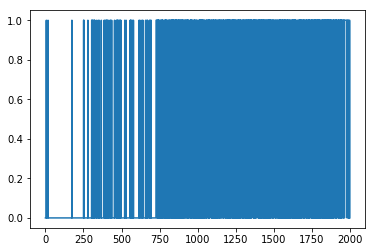

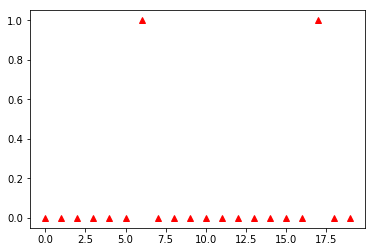

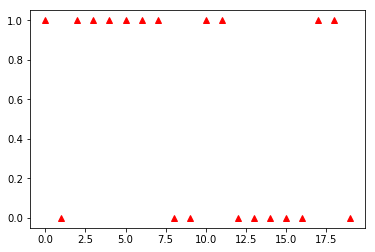

We can see that the network beings to consistly reach the goal around the 750 episode mark.
It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.


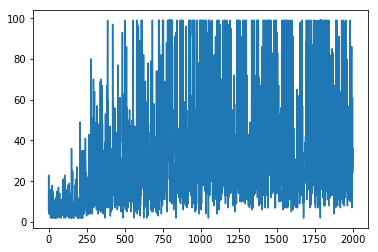

In [16]:
plt.plot(rList)
plt.show()
plt.close()

plt.plot(range(len(rList[:20])), rList[:20], 'r^')
plt.show()
plt.close()

plt.plot(range(len(rList[-20:])), rList[-20:], 'r^')
plt.show()
plt.close()

print("We can see that the network beings to consistly reach the goal around the 750 episode mark.\n"
"It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.")
plt.plot(jList)
plt.show()
plt.close()